 ## i will go throw these processes:-
 - preprocessing
      - data clean  
      - encode  
      - impute
 - feature engineering 
 - model deploy

- make functions that make each step in all the data ( train _test ) and then split them

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import cufflinks as cf
import plotly.express as px
import matplotlib.pylab as plt
from pandas.api.types import CategoricalDtype
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
sns.set_style("whitegrid")
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

In [2]:
def load_data():
    # Read data
    df_train = pd.read_csv( "train.csv", index_col="Id")
    df_test = pd.read_csv("test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

## [1] clean data:-
- searching for missing values
- corrupted data
- ramnaming columns
- replacing elemnts

In [3]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [4]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

In [5]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes(["category","object"]):
        df[name] = df[name].fillna("None")
    return df

In [6]:
df_train, df_test = load_data()

In [7]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,175000.0
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000.0
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500.0


## let's start feature enginearing

- create baseline to judge the feature enginearing

In [8]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    log_y = np.log(y)
    score = cross_val_score(model, X, log_y, cv=5, scoring="neg_mean_squared_error")
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


In [9]:
X = df_train.copy()
y = X.pop("SalePrice")
baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


#### get mi_score

In [10]:
def get_mi_score(X,y):
    for i in X.select_dtypes(["category"]):
        X[i],_=X[i].factorize()
    discreate_features=[pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    scores=mutual_info_regression(X,y,discrete_features=discreate_features,random_state=0)
    series=pd.Series(scores,index=X.columns).sort_values(ascending=False)
    return series

In [11]:
mi_info=get_mi_score(X,y)
mi_info

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Length: 79, dtype: float64

In [12]:
def drop_uninformative(X,mi_info):
    return X.loc[:,mi_info >0.0]

In [13]:
# lets see what happend to the score
v=df_train.copy()
y=v.pop("SalePrice")
v=drop_uninformative(v,mi_info)
score_dataset(v,y)

0.14338026718687277

- the error is reduced by small amount

 ### Step 3 - Create Features¶

- creating features from under standing of data

In [14]:
def group_transformer(df):
    X=pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

In [15]:
# lets see the score after making this
v2=df_train.copy()
y=v2.pop("SalePrice")
v2=drop_uninformative(v2,mi_info)
v2=v2.join(group_transformer(v2))
score_dataset(v2,y)

0.13970219302410603

- it seems as a bad idea

### - creating by cluster

In [16]:
## making features with cluster
def cluster(df):
    features=["LotArea","TotalBsmtSF","FirstFlrSF","SecondFlrSF","GrLivArea"]
    X=df.copy()
    X_scaled=X.loc[:,features]
    X_scaled=(X_scaled-X_scaled.mean(axis=0))/X_scaled.std(axis=0)
    kmeans=KMeans(n_clusters=20,n_init=50,random_state=0)
    x_new=pd.DataFrame()
    x_new["cluster"]=kmeans.fit_predict(X_scaled)
    return x_new
def cluster_distance(df):
    features=["LotArea","TotalBsmtSF","FirstFlrSF","SecondFlrSF","GrLivArea"]
    X=df.copy()
    X_scaled=X.loc[:,features]
    X_scaled=(X_scaled-X_scaled.mean(axis=0))/X_scaled.std(axis=0)
    kmeans=KMeans(n_clusters=20,n_init=50,random_state=0)
    x_new=kmeans.fit_transform(X_scaled)
       
    columnss=[f"col{i}" for i in range(x_new.shape[1])]
    x_new=pd.DataFrame(x_new,columns=columnss)
    return x_new

In [17]:
v3=df_train.copy()
y=v3.pop("SalePrice")
v3=drop_uninformative(v3,mi_info)
v3=v3.join(group_transformer(v3))
v3=v3.join(cluster(v3))
score_dataset(v3,y)

0.13979065050316464

- yeah ... i dosn't heped

In [18]:
v4=df_train.copy()
y=v4.pop("SalePrice")
v4=drop_uninformative(v4,mi_info)
v4=v4.join(group_transformer(v4))
v4=v4.join(cluster(v4))
v4=v4.join(cluster_distance(v4))
score_dataset(v4,y)

0.14342625251320557

- this increased the error.. so it doesn't work

### - creating by making variables form the pca

- normalizing high skew featues

In [24]:
numeric=df_train.select_dtypes(exclude=["category"]).columns
skews=df_train[numeric].skew()
# i will chose that greater that 1 or -1
skews=skews[abs(skews) >1]

In [25]:
skews

LotArea             12.207688
MasVnrArea           2.677616
BsmtFinSF1           1.685503
BsmtFinSF2           4.255261
TotalBsmtSF          1.524255
FirstFlrSF           1.376757
LowQualFinSF         9.011341
GrLivArea            1.366560
BsmtHalfBath         4.103403
KitchenAbvGr         4.488397
WoodDeckSF           1.541376
OpenPorchSF          2.364342
EnclosedPorch        3.089872
Threeseasonporch    10.304342
ScreenPorch          4.122214
PoolArea            14.828374
MiscVal             24.476794
SalePrice            1.882876
dtype: float64

In [26]:
cols_need_normalize=skews.index
cols_need_normalize=cols_need_normalize.drop(["MiscVal","SalePrice"])

In [27]:
def normalize_log(df):
    for i in cols_need_normalize:
        df[i]=np.log1p(df[i])
    return df
norm=df_train.copy()
norm=normalize_log_and_drop_h(norm)

NameError: name 'normalize_log_and_drop_h' is not defined

In [28]:
v4=df_train.copy()
y=v4.pop("SalePrice")
v4=drop_uninformative(v4,mi_info)
v4=v4.join(group_transformer(v4))
v4=v4.join(cluster(v4))
v4=normalize_log(v4)
score_dataset(v4,y)

0.13968137759617366

- tring to remove the outliers of the saleprice 

In [29]:
plt.figure()
px.box(x=df_train["SalePrice"])

<Figure size 432x288 with 0 Axes>

In [30]:
def remove_outliers(df):
    df=df[(df["SalePrice"] >0) & ( df["SalePrice"] <400000)]
    return df

In [31]:
v4=df_train.copy()
v4=remove_outliers(v4)
y=v4.pop("SalePrice")
v4=drop_uninformative(v4,mi_info)
v4=v4.join(group_transformer(v4))
v4=v4.join(cluster(v4))
v4=normalize_log(v4)
score_dataset(v4,y)

0.13806092202215625

- this is the best i can do for now, it neads more feature engineering

In [32]:
def get_best_informative_floats(df,mi_info):
    cols=[col for col in mi_info.index if df[col].dtype in [ "float64","int64"] ]
    s=mi_info[mi_info.index.isin(cols)].sort_values(ascending=False).head(10)
    print(s)

In [33]:
get_best_informative_floats(df_train,mi_info)

GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
TotalBsmtSF     0.368536
GarageArea      0.361542
GarageCars      0.352312
FirstFlrSF      0.282503
YearRemodAdd    0.274032
GarageYrBlt     0.272213
FullBath        0.263217
dtype: float64


In [34]:
def apply_pca(df):
    features = ["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea"]
    X=df.copy()
    X_scaled=X.loc[:,features]
    X_scaled=(X_scaled-X_scaled.mean(axis=0))/X_scaled.std(axis=0)
    pca=PCA()
    transformed=pca.fit_transform(X_scaled)
    columnss=[f"pca{i+1}" for i in range(transformed.shape[1])]
    x_pca=pd.DataFrame(transformed,columns=columnss)
    loading=pd.DataFrame(
        pca.components_.T,
        columns=columnss,
        index=features
    )
    
    return x_pca,loading

In [35]:
x=df_train.copy()
x_pca,loading=apply_pca(x)

In [36]:
loading

,pca1,pca2,pca3,pca4
GarageArea,0.542671,0.055849,0.172729,-0.820094
YearRemodAdd,0.418537,-0.883023,-0.052628,0.205735
TotalBsmtSF,0.518308,0.324224,0.617357,0.495082
GrLivArea,0.511558,0.334709,-0.765680,0.200032


- get the matual info 

<Figure size 432x288 with 0 Axes>

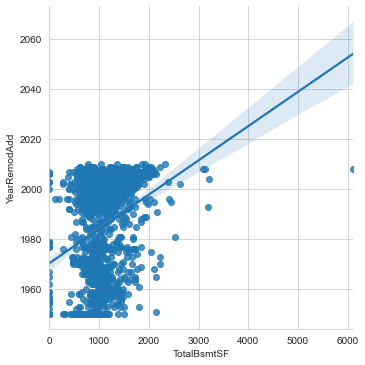

In [37]:
plt.figure()
sns.lmplot(y="YearRemodAdd",x="TotalBsmtSF",fit_reg=True,data=df_train)

_ plotting the ralations to see the relations

<AxesSubplot:>

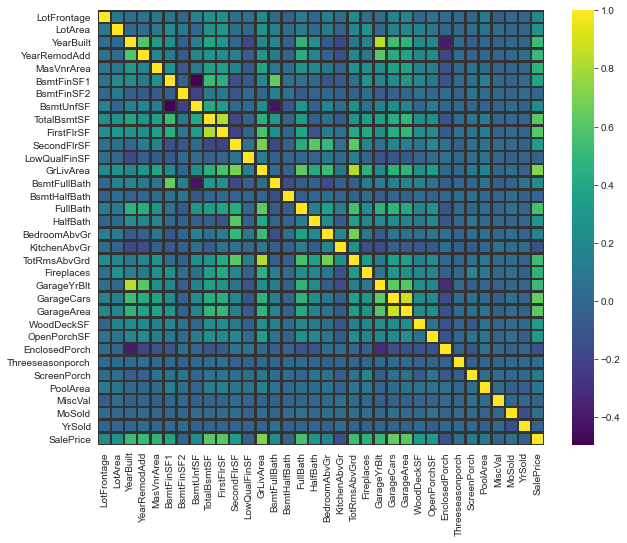

In [38]:

plt.figure(figsize=(10,8))
sns.heatmap(df_train[numeric].corr(),cmap="viridis",linecolor="#333",linewidths=1.5)

In [39]:
def pca_features(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
#     X["Feature3"]=df.BsmtFinSF1 - df.BsmtUnfSF
    return X


- now , lets try

In [40]:
v5=df_train.copy()
v5=remove_outliers(v5)
y=v5.pop("SalePrice")
v5=drop_uninformative(v5,mi_info)
v5=v5.join(group_transformer(v5))
v5=v5.join(cluster(v5))
v5=v5.join(pca_features(v5))
v5=normalize_log(v5)
score_dataset(v5,y)

0.13447001427945654

- target endoder

In [41]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [42]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


In [43]:
v6=df_train.copy()
v6=remove_outliers(v6)
y=v6.pop("SalePrice")
v6=drop_uninformative(v6,mi_info)
v6=v6.join(group_transformer(v6))
v6=v6.join(cluster(v6))
v6=v6.join(pca_features(v6))
# encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
# v6 = v6.join(encoder.fit_transform(v6, y, cols=["MSSubClass"]))
v6=normalize_log(v6)
score_dataset(v6,y)


0.13447001427945654

In [44]:
def create_fs(df1):
    X=df1.copy()
    X=remove_outliers(X)
    y=X.pop("SalePrice")
    mi_info=get_mi_score(X,y)
    X=drop_uninformative(X,mi_info)
    X=X.join(group_transformer(X))
    X=X.join(cluster(X))
    X=X.join(pca_features(X))
    X=normalize_log(X)
    X=label_encode(X)
    return X,y
   

In [45]:
df_train,df_test=load_data()
x,y=create_fs(df_train)
score_dataset(x,y)

0.1361763294657965

In [66]:
xgb_params = dict(                   # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1500,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1
)

xgb = XGBRegressor(**xgb_params)
score_dataset(x, y, xgb)

0.1265147163340839

In [98]:
def create_fs2(df_train,df_test=None):
    X=df_train.copy()
    X=remove_outliers(X)
    y=X.pop("SalePrice")
    mi_info=get_mi_score(X,y)
    X=drop_uninformative(X,mi_info)
    X=X.join(group_transformer(X))
    X=X.join(cluster(X))
    X=X.join(pca_features(X))
    X=normalize_log(X)
    X=label_encode(X)
    if df_test is not None:
        X_test=df_test.copy()
        features=mi_info[mi_info >0 ].index
        X_test=X_test.loc[:,features]
        X_test=X_test.join(group_transformer(X_test))
        X_test=X_test.join(cluster(X_test))
        X_test=X_test.join(pca_features(X_test))
        X_test=normalize_log(X_test)
        X_test=label_encode(X_test)
        return X,X_test,y
    else:
        return X,y
   

In [104]:
train,test=load_data()
x_train,x_test,y=create_fs2(train,test)
x_train,x_test=x_train.align(x_test,join="left",axis=1)

In [105]:
x_train.shape

(1432, 80)

In [106]:
x_test.shape

(1459, 80)

In [115]:
# model 
model=XGBRegressor(n_estimators=1500,learning_rate=.01,random_state=0)
model.fit(x_train,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [116]:
y_pred=np.log(model.predict(x_test))

In [117]:
y_test=pd.read_csv("sample_submission.csv")
y_test

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [118]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_pred,np.log(y_test["SalePrice"])))

0.5667625425791629